# **Predicting emissions using the _XARIMA_ model**

## Imports

In [31]:
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

import sys
sys.path.append('../src')
from utils import *

## Importing timeseries

In [16]:
# Read preprocessed data
data_raw = pd.read_csv('../data/processed/final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [17]:
# Split data according to category
data = split(data_raw)

Let's take a look at the unique dates to have an idea of the size of our time series.

In [18]:
for key in data.keys():
    print(f'Column: {key}'.ljust(19, ' ') + '--->' + f'Size = {data[key].date_etablissement_dpe.unique().shape[0]}'.rjust(12, ' '))

Column: admin      ---> Size = 4252
Column: centre_com ---> Size = 3418
Column: occup_cont ---> Size = 3246
Column: autre      ---> Size = 4043


Now, let's aggregate the data.

In [19]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'ME']} for key, df in data.items()}

For instance,

In [20]:
ts['admin']['W']  # ts['sector']['frequency']

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2013-01-13,1974.000000,100.000000,661276.385727,6.863710e+06,27.130000
2013-01-20,1974.000000,100.000000,642131.351753,6.841609e+06,27.515000
2013-01-27,1974.000000,100.000000,622986.317779,6.819508e+06,27.900000
2013-02-03,1974.000000,100.000000,603841.283805,6.797406e+06,28.285000
2013-02-10,1974.000000,100.000000,584696.249830,6.775305e+06,28.670000
...,...,...,...,...,...
2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06,11.360938
2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06,8.770826
2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06,9.580173


## Prediction and validation

Now let's apply our model to predict `ts['admin']` values. First let's do a train test split for every time series.

In [21]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ttsplit(ts[sect][freq])
        ts[sect][freq] = {'train': train, 'test': test}

For instance,

In [22]:
ts['admin']['W']['train'].tail()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2021-12-05,1973.443051,294.061644,669780.954562,6.610451e+06,9.323881
2021-12-12,1970.556142,250.735492,654698.968087,6.647732e+06,10.502186
2021-12-19,1971.476040,466.225404,651926.460193,6.639262e+06,10.352466
2021-12-26,1969.239052,280.367678,645668.676023,6.704144e+06,11.452941
2022-01-02,1964.616258,149.333108,658101.675612,6.669188e+06,12.024793


In [23]:
ts['admin']['W']['test'].head()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2022-01-09,1969.312994,520.815215,620617.402066,6.670510e+06,12.948173
2022-01-16,1969.147755,361.690374,664686.816562,6.624619e+06,12.886822
2022-01-23,1974.686615,216.371506,648555.047141,6.668022e+06,11.216982
2022-01-30,1967.878830,244.195668,633763.196287,6.642269e+06,9.623095
2022-02-06,1968.647627,251.551112,696000.296617,6.622129e+06,10.534374


We use the best fits found in `arima.py` t predict each time series for each frequency.

In [24]:
best_fits = {'admin': {'D': (0, 1, 2), 'W': (1, 1, 1), 'ME': (0, 1, 2)}, 
             'centre_com': {'D': (1, 1, 1), 'W': (1, 1, 1), 'ME': (1, 1, 1)}, 
             'occup_cont': {'D': (1, 1, 1), 'W': (0, 1, 2), 'ME': (1, 1, 1)}, 
             'autre': {'D': (1, 1, 1), 'W': (0, 1, 1), 'ME': (1, 1, 1)}}

In [25]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ts[sect][freq]['train'], ts[sect][freq]['test']
        model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=best_fits[sect][freq])
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
        ts[sect][freq]['pred'] = pred

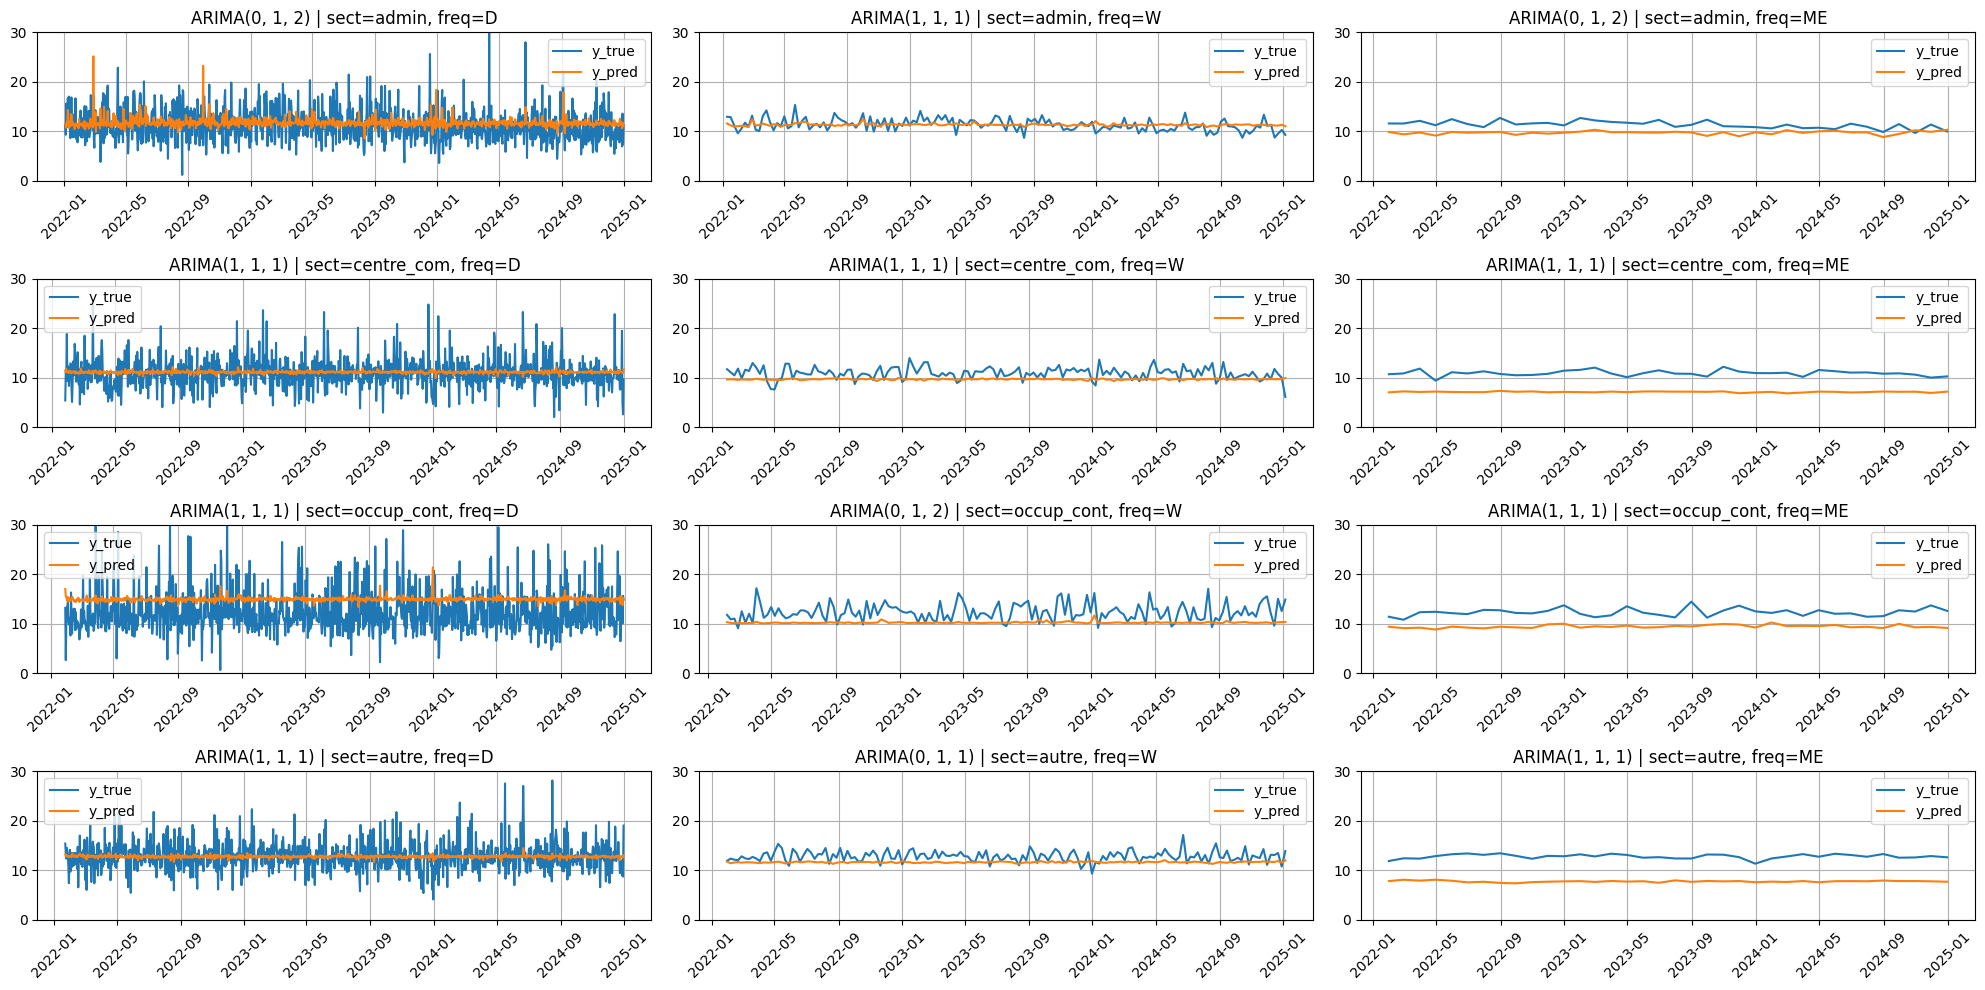

In [30]:
n, m = 4, 3
fig, axs = plt.subplots(n, m, figsize=(20,10))
for i, sect in enumerate(ts):
    for j, freq in enumerate(ts[sect]):
        train, test, pred = ts[sect][freq].values()
        n = len(test)
        axs[i, j].plot(test.emission_ges, label='y_true')
        axs[i, j].plot(pred, label='y_pred')
        axs[i, j].legend()
        axs[i, j].set_title(f'ARIMA{best_fits[sect][freq]} | sect={sect}, freq={freq}')
        axs[i, j].set_ylim(0, 30)
        axs[i, j].grid(True)
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [32]:
rmse = pd.DataFrame({sect: {freq: f'{mean_squared_error(y_true=ts[sect][freq]['test'].emission_ges, y_pred=ts[sect][freq]['pred']):05.2f}' for freq in ts[sect]} for sect in ts })
rmse

,admin,centre_com,occup_cont,autre
D,10.01,08.27,23.61,07.56
W,01.36,03.02,07.39,02.67
ME,03.24,14.70,08.81,25.66


It seems that with a _weekly_ frequency, we get the best fits.

## Model comparison

Now let's consider the orders bellow and compare the performance of the _ARIMA_ model for the weekly frequency for each sector.

In [33]:
orders = [(0, 1, 1), (0, 1, 2), (1, 1, 1), (0, 1, 3)]

for sect in ts:
    for freq in ts[sect]:
        ts[sect][freq]['pred'] = {}
        for order in orders:
            train, test = ts[sect][freq]['train'], ts[sect][freq]['test']
            model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
            ts[sect][freq]['pred'][order] = pred

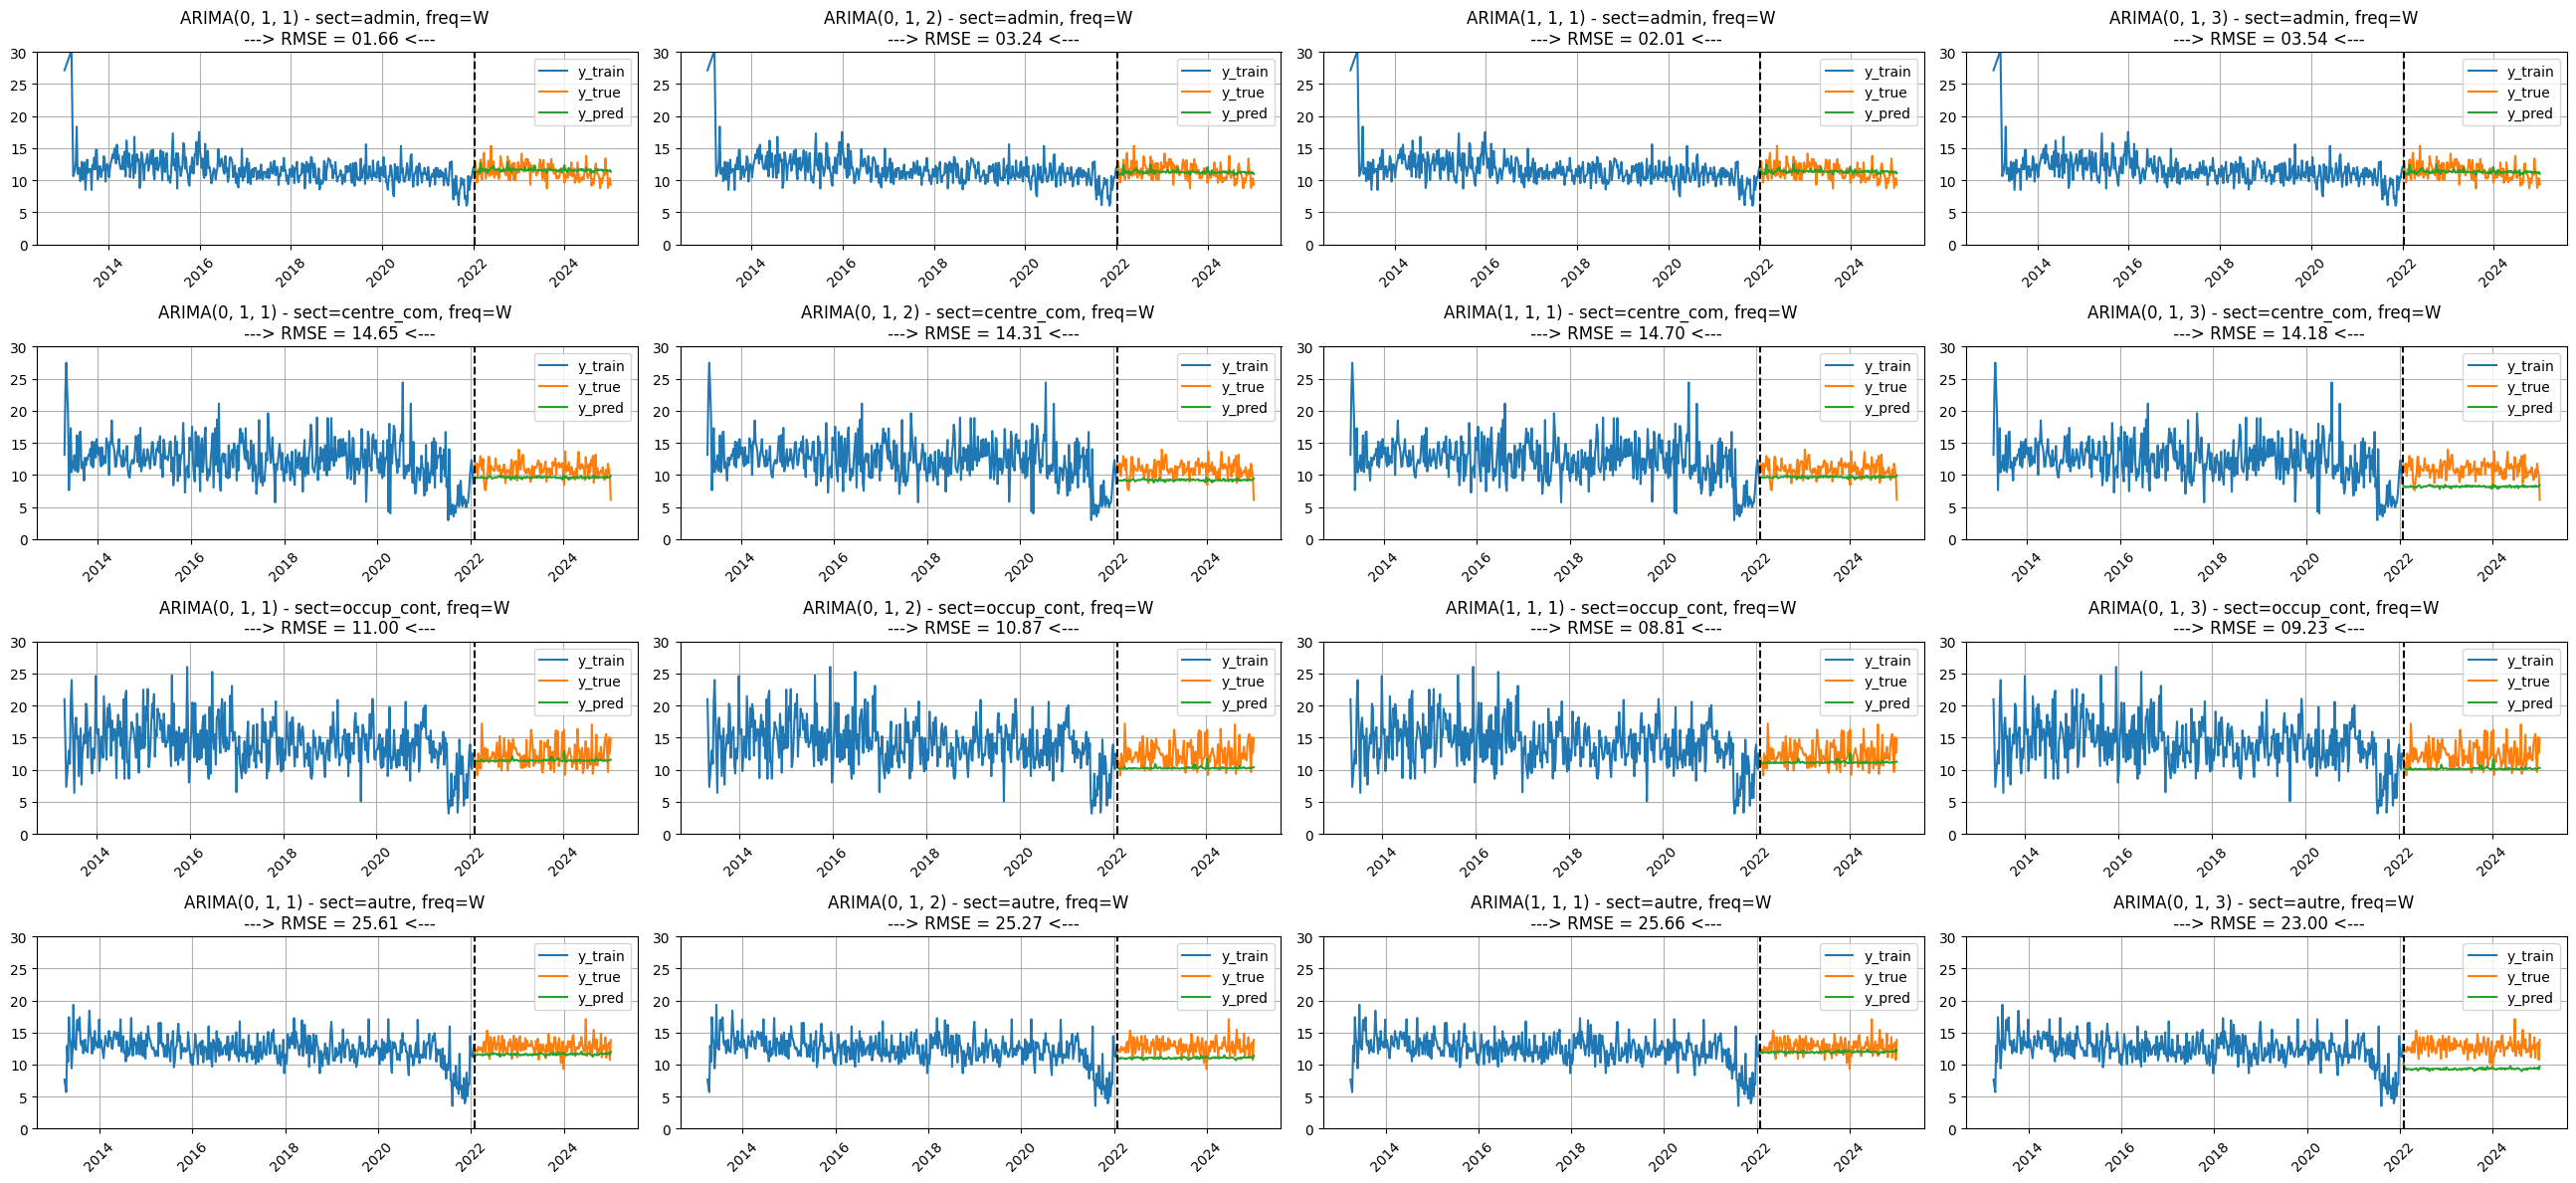

In [36]:
n, m = 4, 4
fig, axs = plt.subplots(n, m, figsize=(26,12))

for i, sect in enumerate(ts):
    for j, order in enumerate(ts[sect]['W']['pred']):
        train, test, pred = ts[sect]['W']['train'], ts[sect]['W']['test'], ts[sect]['W']['pred'][order]
        train_extended = extend_train(train, test)
        n = len(test)
        axs[i, j].plot(train_extended.emission_ges, label='y_train')
        axs[i, j].plot(test.emission_ges, label='y_true')
        axs[i, j].plot(pred, label='y_pred')
        axs[i, j].legend()
        rmse = f'{mean_squared_error(y_true=ts[sect][freq]['test'].emission_ges, y_pred=ts[sect][freq]['pred'][order]):05.2f}'
        axs[i, j].set_title(f'ARIMA{order} - sect={sect}, freq=W \n ---> RMSE = {rmse} <---')
        axs[i, j].set_ylim(0, 30)
        axs[i, j].grid(True)
        axs[i, j].axvline(x=test.index[0], color='black', linestyle='--')
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

We can see that all the order are comparable in global RMSE.

Let's now check out the global trend using the model _ARIMA(0, 1, 2)_, for instance.

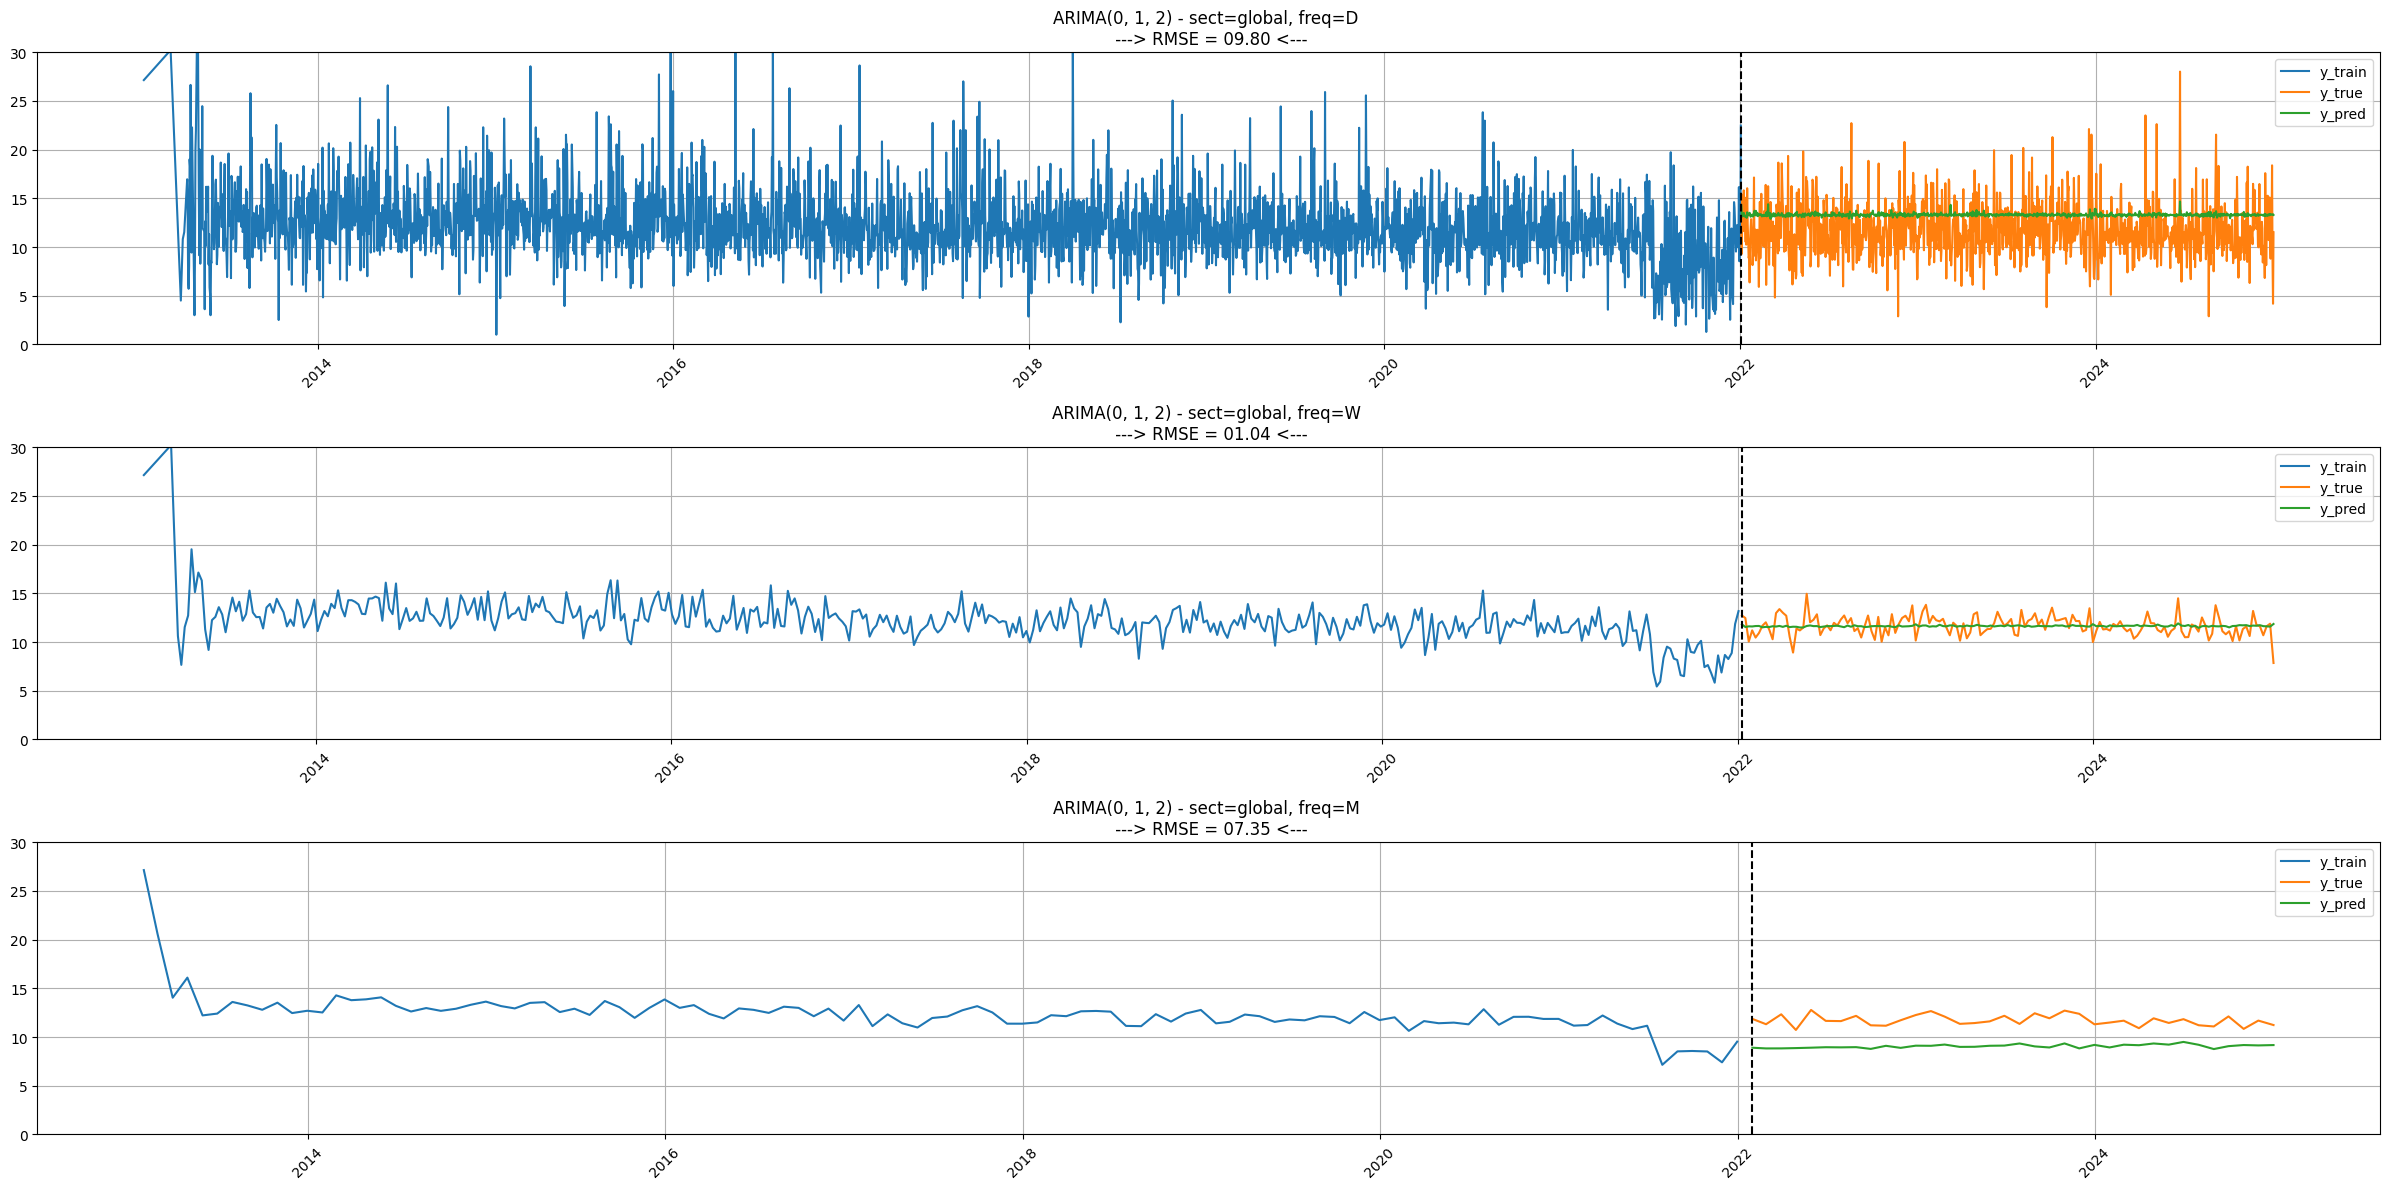

In [38]:
n, m = 3, 1
fig, axs = plt.subplots(n, m, figsize=(24,12))

global_ts = {}
for i, freq in enumerate(['D', 'W', 'M']):
    global_ts_freq = extract_vect_ts(data_raw, freq=freq)
    train, test = ttsplit(global_ts_freq)
    train_extended = extend_train(train, test)
    model = ARIMA(endog=train.emission_ges, exog=train.drop(columns='emission_ges'), order=(0, 1, 2))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=len(test), exog=test.drop(columns='emission_ges'))
    axs[i].plot(train_extended.emission_ges, label='y_train')
    axs[i].plot(test.emission_ges, label='y_true')
    axs[i].plot(pred, label='y_pred')
    axs[i].legend()
    rmse = f'{mean_squared_error(y_true=test.emission_ges, y_pred=pred):05.2f}'
    axs[i].set_title(f'ARIMA(0, 1, 2) - sect=global, freq={freq} \n ---> RMSE = {rmse} <---')
    axs[i].set_ylim(0, 30)
    axs[i].grid(True)
    axs[i].axvline(x=test.index[0], color='black', linestyle='--')
    plt.setp(axs[i].get_xticklabels(), rotation=45)
    global_ts[freq] = {'train': train, 'test': test, 'pred': pred}
plt.tight_layout()
plt.show()

## Auto ARIMA

### Weekly frequency

We will now use the `auto_arima` Python module to try and determine the best model that will capture the global variations with a weekly frequency.

In [39]:
model = auto_arima(y=global_ts['W']['train'].emission_ges, X=global_ts['W']['train'].drop(columns='emission_ges'))

Let's check out the distribution of the residuals.

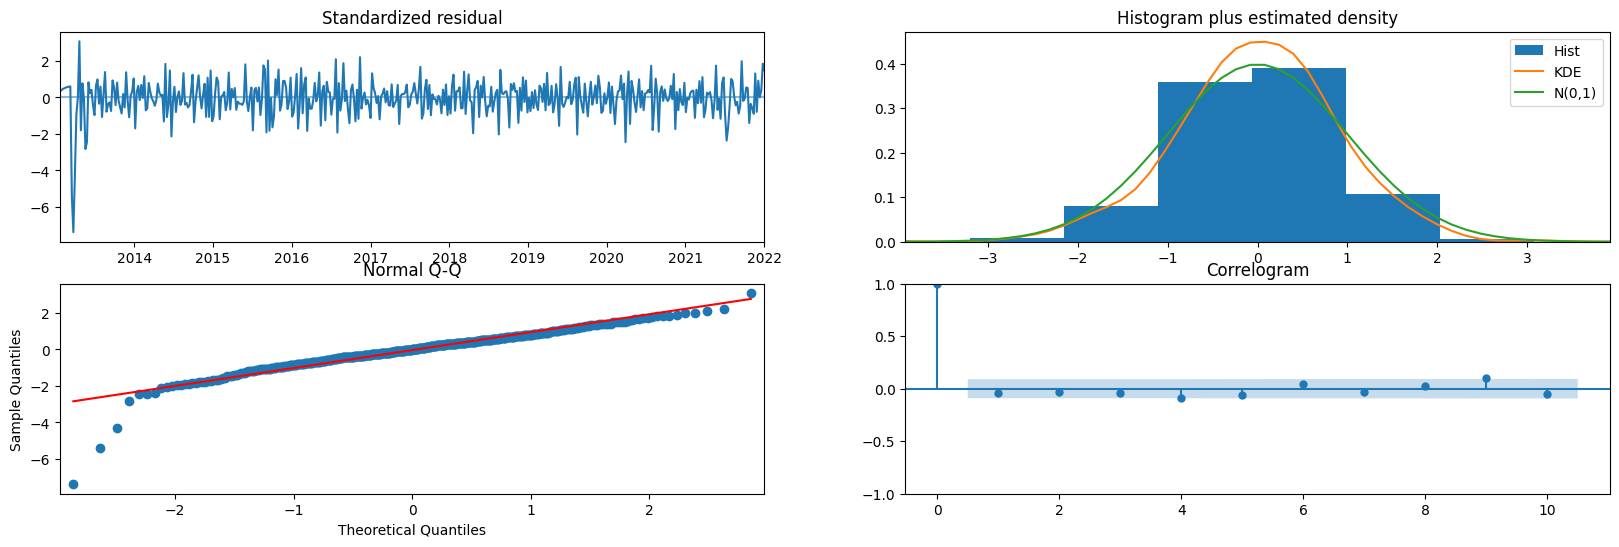

In [43]:
model.plot_diagnostics(figsize=(20, 6))
plt.show()

The residuals follow a normal law of mean $0$. The model seems really solid.

Now let's plot the predictions.

In [44]:
pred = model.predict(n_periods=len(global_ts['W']['test']), X=global_ts['W']['test'].drop(columns='emission_ges'))
global_ts['W']['pred'] = pred

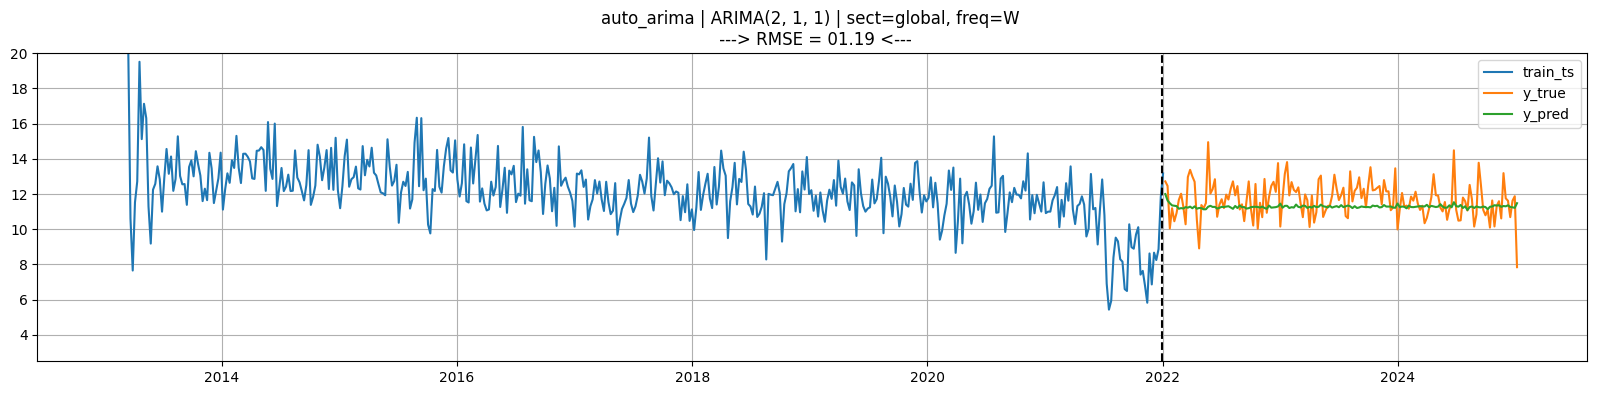

In [47]:
fig = plt.figure(figsize=(20, 4))
rmse = f'{mean_squared_error(y_true=global_ts['W']['test'].emission_ges, y_pred=global_ts['W']['pred']):05.2f}'
plt.plot(extend_train(global_ts['W']['train'], global_ts['W']['test']).emission_ges, label='train_ts')
plt.plot(global_ts['W']['test'].emission_ges, label='y_true')
plt.plot(global_ts['W']['pred'], label='y_pred')
plt.axvline(x=train.index[-1], color='black', linestyle='--')
plt.ylim(2.5, 20)
plt.grid(True)
plt.legend()
plt.title(f'auto_arima | ARIMA(2, 1, 1) | sect=global, freq=W \n ---> RMSE = {rmse} <---')
plt.show()

The results are a little bit more satisfying than the simple historical _ARIMA_ approach in `arima.ipynb`.

### Rolling mean

Finally, we are going to test a rolling mean approach to predict the trend only.

In [48]:
smooth_global_ts_w = {tt: rolling_average(global_ts['W'][tt], window=10) for tt in ['train', 'test']}  
pred = model.predict(n_periods=len(smooth_global_ts_w['test']), X=smooth_global_ts_w['test'].drop(columns='emission_ges'))
smooth_global_ts_w['pred'] = pred

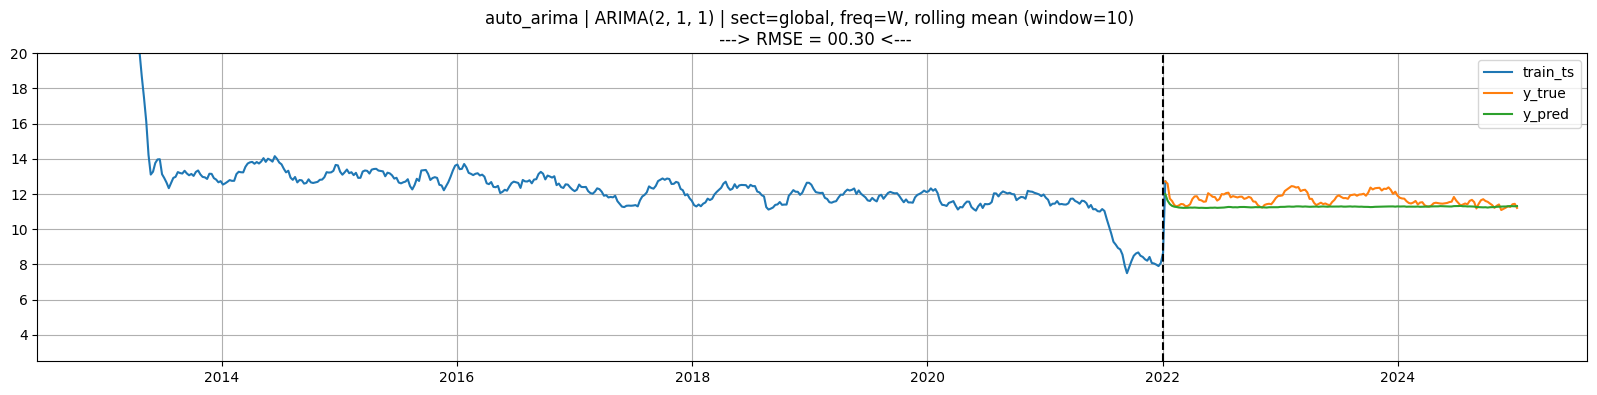

In [52]:
fig = plt.figure(figsize=(20, 4))
rmse = f'{mean_squared_error(y_true=smooth_global_ts_w['test'].emission_ges, y_pred=smooth_global_ts_w['pred']):05.2f}'
train, test, pred = smooth_global_ts_w['train'].emission_ges, smooth_global_ts_w['test'].emission_ges, smooth_global_ts_w['pred']
train_extended = extend_train(train, test)
plt.plot(train_extended, label='train_ts')
plt.plot(test, label='y_true')
plt.plot(pred, label='y_pred')
plt.axvline(x=train.index[-1], color='black', linestyle='--')
plt.ylim(2.5, 20)
plt.grid(True)
plt.legend()
plt.title(f'auto_arima | ARIMA(2, 1, 1) | sect=global, freq=W, rolling mean (window=10) \n ---> RMSE = {rmse} <---')
plt.show()

We can clearly see that this rolling average approach yields better results for the general trend in terms of RMSE. But this can be explained by the smoothing effect of the rolling mean transformation that flattens the variations.

## Conclusion

Compared to the simple _ARIMA_ model that only predicts based on historical values, _XARIMA_ uses exogenous variable which makes it a little noisier, trying to capture the real time variations of the timeseries, rather than the simple horizontal lines predicted by _ARIMA_.